# Blind Detection

### Notes
Niek ruben max AI studenten startup.

transfer learning

Evaluation with labels

change model to sklearn tutorial


## On the  data set 

The dataset provides a large set of retina images taken using fundus photography under a variety of imaging conditions.
A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0.  No DR
1.  Mild
2.  Moderate
3.  Severe
4.  Proliferative DR

5.  Other disease

### Oog arts tips:
De ernst van de Diabetische retinopathie kan een afspiegeling zijn van het rest van het lichaam voor een diabetes patient.

5 is required want een oogarts zou dit zien en doorverwijzen ook als dat niet oorspronkelijk het doel was. Als dit niet werkt dan wordt het product hoogst waarschijnlijk niet gebruikt.
    5 is niet nodig als er al een regelmatige check van een oog arts is (elke 2/4 jaar)

This data set contains noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation.

## Considered Datasets
### Dataset 1
Dataset of eyes with and without Diabetische retinopathie: <br>
https://www.kaggle.com/donkeys/retinopathy-train-2015?select=trainLabels.csv

Op 3 plekken worden diabetes screeningen gedaan voor de ogen
1. ziekenhuis
2. kliniek (prive ziekenhuis)
3. optiek zaken (optimitrist voert het onderzoek voor de ogen uit)
    - maakt foto van netvlies
    - dan kijken hoe goed hij kan kijken

Als de ernst moderate of erger is dan worden de foto's altijd door een oog arts bekeken in een ziekenhuis of kliniek
<br>
Grootste voordeel: Zou de foto's kunnen laten maken door niet gespecialiseerd personeel wat geld en tijd kan schelen voor de diabetes patienten en artsen.

### Choice
We besloten dat dataset 1 de meeste waarde voor de oogzorg in combinatie met de beste kans op slagen heeft.

## sckitlearn classification
apply grid search and corss validation after getting it to work

In [24]:
# File moving imports
import os
import shutil

# Standard scientific Python imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import datasets, classifiers and performance metrics
import skimage.io as io
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

#save model
from joblib import dump, load


## Labels

In [35]:
labels = pd.read_csv("C:/Users/mauri/Documents/GitHub/EyeDiseaseDetection/Data/DrpTest/trainLabels.csv")

In [26]:
labels_reset = labels.set_index('image')
# labels_reset[['level']]

label_list =(labels_reset[['level']].values.flatten().tolist())

In [27]:
label_list = np.asarray(label_list)
label_list

array([0, 0, 0, ..., 0, 0, 1])

In [28]:
label_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
label_names[label_list[1]]

'No DR'

In [29]:
label_list = label_list[0:1592]
label_list[0]

0

## Model

In [30]:
def transformImage(f, img_num=None):
        img = io.imread(f)
        im_res = resize(img,(597, 896))
        return im_res

def transformImageFlat(f, img_num=None):
        img = io.imread(f)
        # im_res = resize(img,(597, 896))
        ## Turn images grey
        img_gray = rgb2gray(img)        
        im_res = resize(img_gray,(597, 896))
        im_res = np.reshape(im_res, 534912)

        return im_res

In [31]:
if __name__ == "__main__":
    img_collections = io.ImageCollection('Data/testSet/*.png',load_func=transformImage)
    img_collectionsFlat = io.ImageCollection('Data/testSet/*.png',load_func=transformImageFlat)

In [32]:
i = 0
print(img_collections[i].shape)
print(img_collectionsFlat[i].shape)

(597, 896, 3)
(534912,)


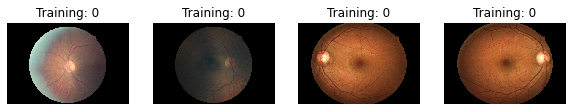

In [33]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, img_collections, label_list):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [24]:
# flatten the images
n_samples = len(img_collections)
data = img_collectionsFlat

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, label_list, test_size=0.3, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

NameError: name 'predicted' is not defined

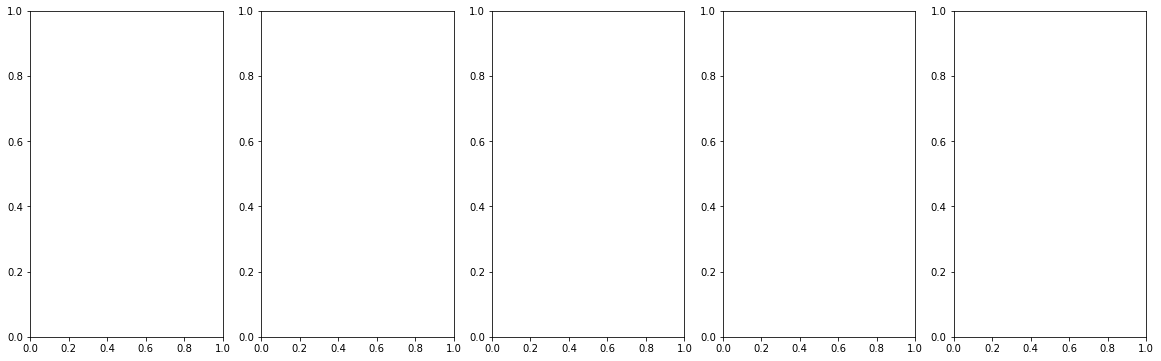

In [30]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
for ax, image, prediction, realCat in zip(axes, X_test, predicted, y_test):
    ax.set_axis_off()
    image = image.reshape(597, 896)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Pred: {prediction} Real: {realCat}")

### Evaluation

In [14]:
print(
    f"CLassification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

NameError: name 'clf' is not defined

## Biased dataset issue
It seems that 73% of the data is category 0, making classification models predict everything as such.

In [15]:
temp = labels_reset.apply(pd.value_counts)
temp['percent'] = temp['level']
for index, column in enumerate(temp['level']):
    temp.at[index, 'percent'] = ((temp.at[index, 'percent']) / 35126 * 100)
temp.at[5, 'percent'] = 100
temp.at[5, 'level'] = 35126
temp

,level,percent
0,25810.0,73.0
2,5292.0,15.0
1,2443.0,6.0
3,873.0,2.0
4,708.0,2.0
5,35126.0,100.0


In order to fix this issue with the data set all categories should be relatively similarly present.

creating even partitions would lead to a 708*5=3540 data set size.

Code requirements:
Create a list of labels that includes an even amount of all categories.
Create a way for the algorithm to only load the images in the list.